In [3]:
import yfinance as yf
import pandas as pd

# get the data
def fetch_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return data

# Using a broad index and sector ETFs
tickers = ['^STOXX50E', 'XLK', 'XLE']
start_date = '2023-01-01'
end_date = '2023-12-31'
data = fetch_data(tickers, start_date, end_date)

for ticker, df in data.items():
    print(f"{ticker}: {df.head()}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

^STOXX50E:                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-01-03  3852.070068  3921.370117  3852.070068  3882.290039  3882.290039   
2023-01-04  3891.040039  3975.500000  3891.040039  3973.969971  3973.969971   
2023-01-05  3967.010010  3974.610107  3950.419922  3959.479980  3959.479980   
2023-01-06  3959.959961  4017.850098  3951.929932  4017.830078  4017.830078   
2023-01-09  4027.510010  4080.550049  4025.159912  4068.620117  4068.620117   

              Volume  
Date                  
2023-01-03  33158800  
2023-01-04  39907300  
2023-01-05  26926500  
2023-01-06  28231800  
2023-01-09  32735200  
XLK:                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  125.769997  126.599998  122.379997  123.260002  121.785118   
2023-01-04  123.900002  124.370003  122.220001 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


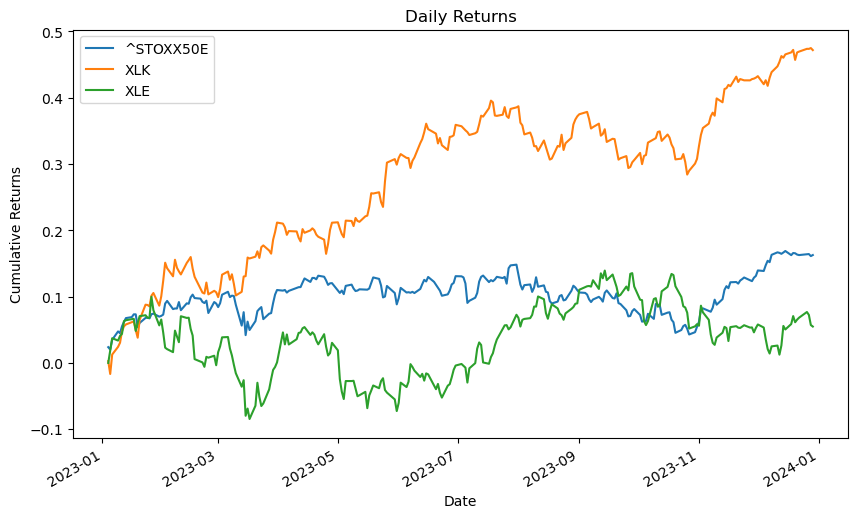

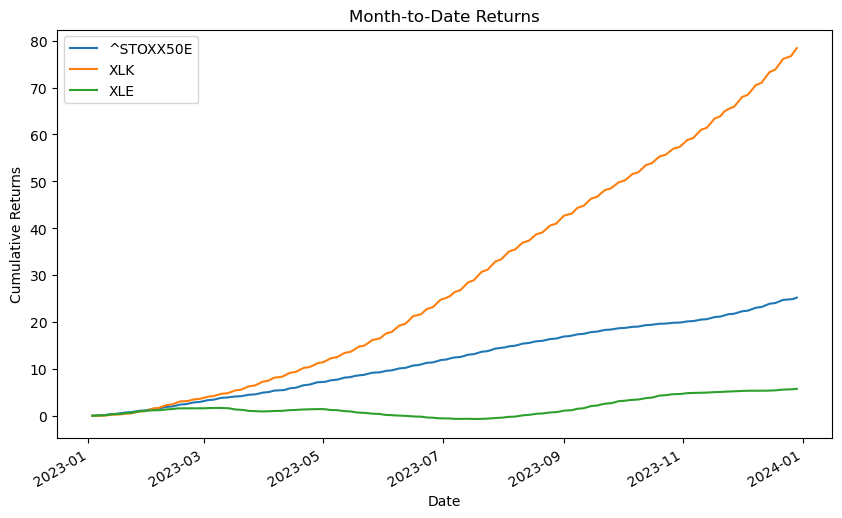

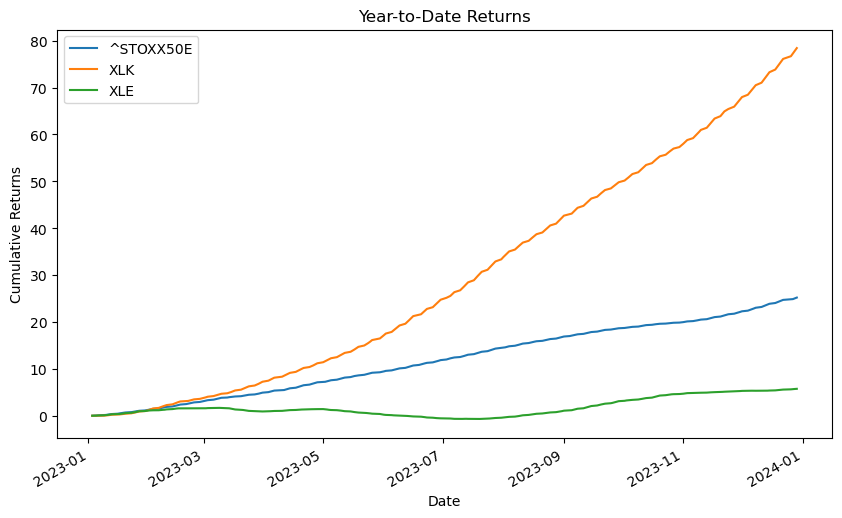

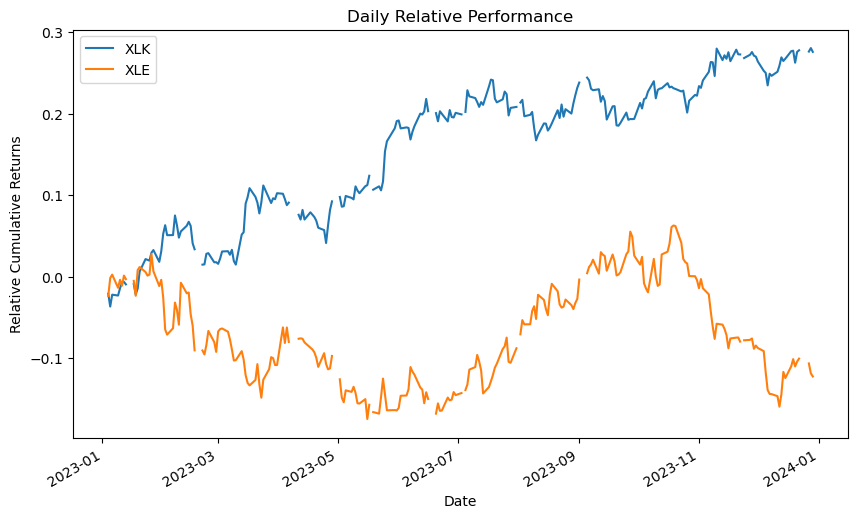

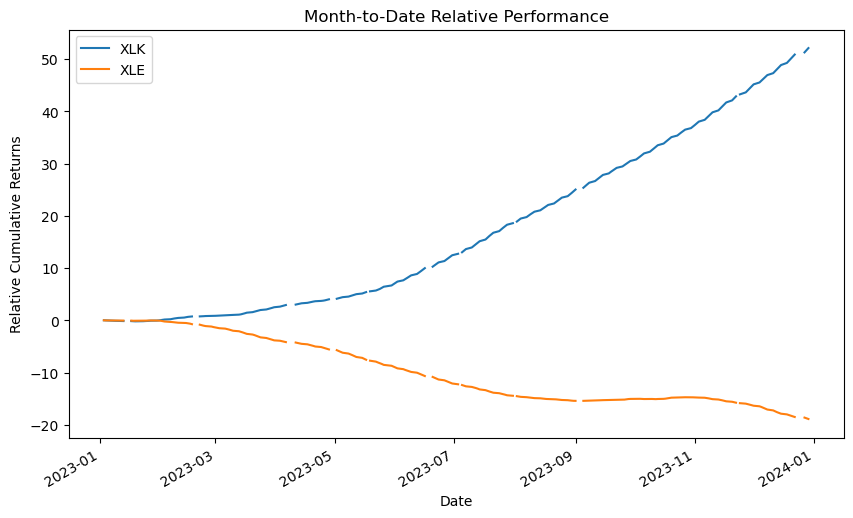

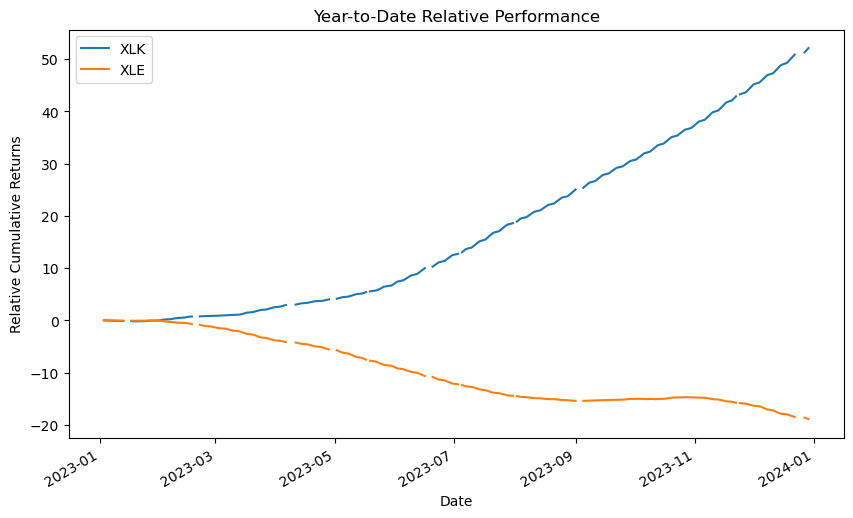

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Fetch historical data
def fetch_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return data

tickers = ['^STOXX50E', 'XLK', 'XLE']  
start_date = '2023-01-01'
end_date = '2023-12-31'
data = fetch_data(tickers, start_date, end_date)

# Calculate returns
def calculate_returns(data, interval='daily'):
    returns = {}
    for ticker, df in data.items():
        if interval == 'daily':
            returns[ticker] = df['Adj Close'].pct_change()
        elif interval == 'm-d-t':
            returns[ticker] = df['Adj Close'] / df['Adj Close'].iloc[0] - 1
        elif interval == 'y-t-d':
            returns[ticker] = df['Adj Close'] / df['Adj Close'].iloc[0] - 1
    return returns

daily_returns = calculate_returns(data, interval='daily')
mdt_returns = calculate_returns(data, interval='m-d-t')
ytd_returns = calculate_returns(data, interval='y-t-d')

# Calculate relative performance against the benchmark (^STOXX50E)
def relative_performance(returns, benchmark='^STOXX50E'):
    rel_perf = {}
    benchmark_returns = returns[benchmark]
    for ticker, ret in returns.items():
        if ticker != benchmark:
            rel_perf[ticker] = ret - benchmark_returns
    return rel_perf

rel_perf_daily = relative_performance(daily_returns)
rel_perf_mdt = relative_performance(mdt_returns)
rel_perf_ytd = relative_performance(ytd_returns)

# Plotting
def plot_performance(returns, title):
    plt.figure(figsize=(10, 6))
    for ticker, ret in returns.items():
        ret.cumsum().plot(label=ticker)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

def plot_relative_performance(rel_perf, title):
    plt.figure(figsize=(10, 6))
    for ticker, ret in rel_perf.items():
        ret.cumsum().plot(label=ticker)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Relative Cumulative Returns')
    plt.legend()
    plt.show()

def plotly_performance(returns, title):
    fig = px.line(title=title)
    for ticker, ret in returns.items():
        fig.add_scatter(x=ret.index, y=ret.cumsum(), mode='lines', name=ticker)
    fig.show()

# Plot historical and relative performance
plot_performance(daily_returns, 'Daily Returns')
plot_performance(mdt_returns, 'Month-to-Date Returns')
plot_performance(ytd_returns, 'Year-to-Date Returns')
plot_relative_performance(rel_perf_daily, 'Daily Relative Performance')
plot_relative_performance(rel_perf_mdt, 'Month-to-Date Relative Performance')
plot_relative_performance(rel_perf_ytd, 'Year-to-Date Relative Performance')

# The Interactive Dashboard using Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Sector Performance Analysis'),
    dcc.Dropdown(
        id='sector-dropdown',
        options=[{'label': ticker, 'value': ticker} for ticker in tickers],
        value='^STOXX50E'
    ),
    dcc.Graph(id='performance-graph'),
    dcc.Graph(id='relative-performance-graph'),
])

@app.callback(
    [Output('performance-graph', 'figure'), Output('relative-performance-graph', 'figure')],
    [Input('sector-dropdown', 'value')]
)
def update_graph(selected_sector):
    fig_perf = px.line(title='Sector Performance')
    for ticker, ret in daily_returns.items():
        fig_perf.add_scatter(x=ret.index, y=ret.cumsum(), mode='lines', name=ticker)
    
    fig_rel_perf = px.line(title='Relative Performance')
    for ticker, ret in rel_perf_daily.items():
        if ticker == selected_sector:
            fig_rel_perf.add_scatter(x=ret.index, y=ret.cumsum(), mode='lines', name=ticker)
    
    return fig_perf, fig_rel_perf

if __name__ == '__main__':
    app.run_server(debug=True)


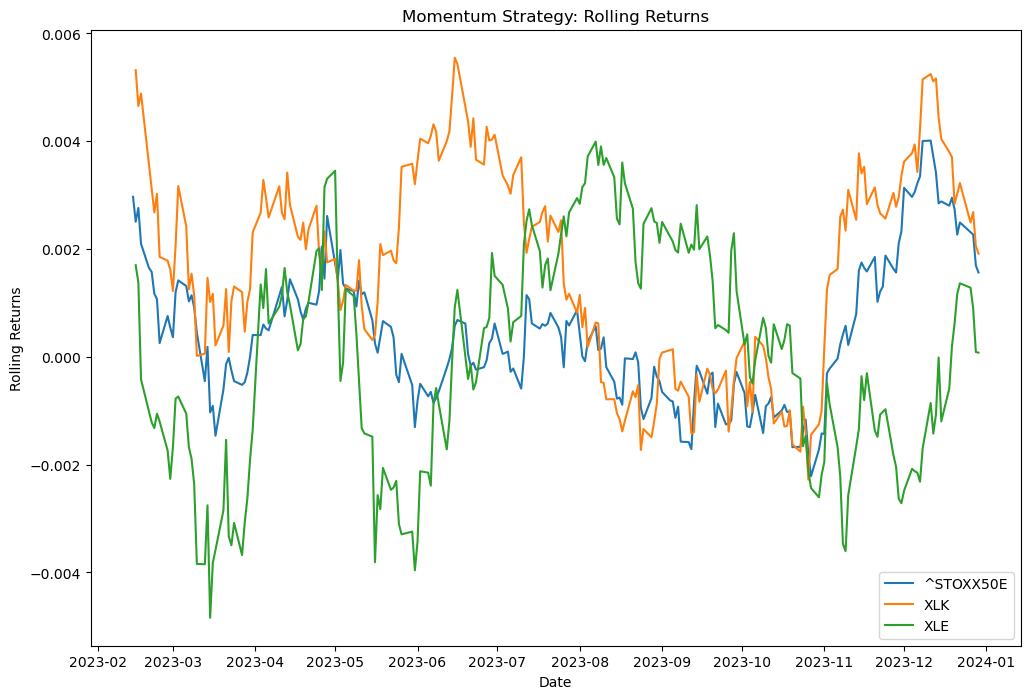

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate rolling returns for momentum strategy
def calculate_rolling_returns(returns, window=30):
    rolling_returns = {}
    for ticker, ret in returns.items():
        rolling_returns[ticker] = ret.rolling(window=window).mean()
    return rolling_returns

rolling_returns = calculate_rolling_returns(daily_returns, window=30)

# Plot momentum strategy
def plot_momentum_strategy(rolling_returns, benchmark='^STOXX50E'):
    plt.figure(figsize=(12, 8))
    for ticker, ret in rolling_returns.items():
        plt.plot(ret.index, ret, label=ticker)
    plt.title('Momentum Strategy: Rolling Returns')
    plt.xlabel('Date')
    plt.ylabel('Rolling Returns')
    plt.legend()
    plt.show()

plot_momentum_strategy(rolling_returns)


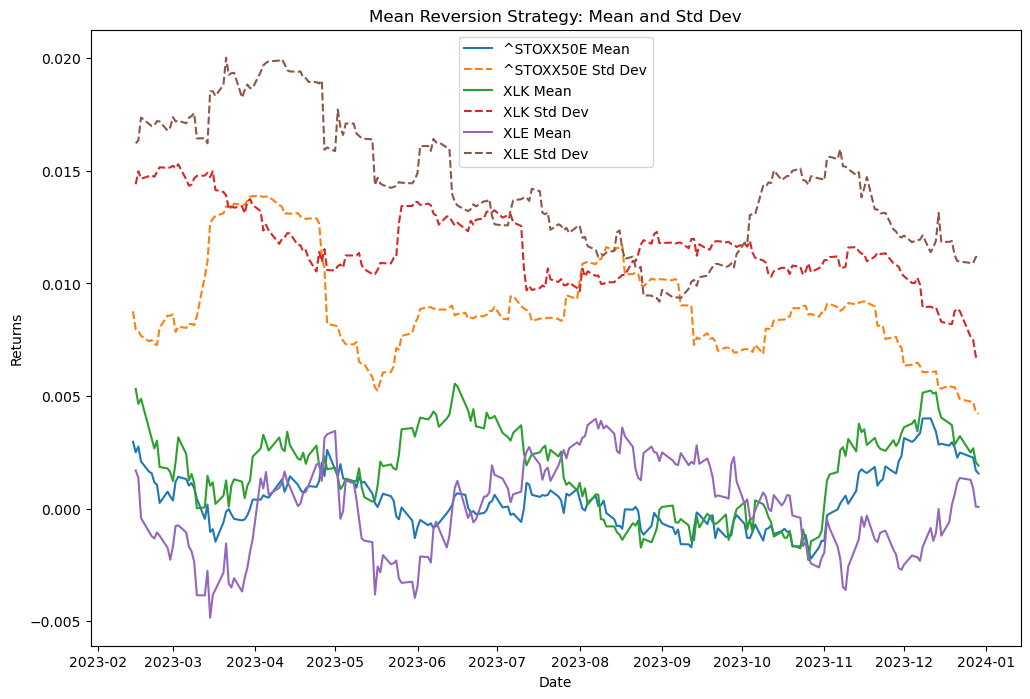

In [6]:
# Calculate mean and standard deviation
def calculate_mean_reversion(returns):
    mean_returns = {}
    std_returns = {}
    for ticker, ret in returns.items():
        mean_returns[ticker] = ret.rolling(window=30).mean()
        std_returns[ticker] = ret.rolling(window=30).std()
    return mean_returns, std_returns

mean_returns, std_returns = calculate_mean_reversion(daily_returns)

# Plot mean reversion strategy
def plot_mean_reversion_strategy(mean_returns, std_returns):
    plt.figure(figsize=(12, 8))
    for ticker in mean_returns.keys():
        plt.plot(mean_returns[ticker].index, mean_returns[ticker], label=f'{ticker} Mean')
        plt.plot(std_returns[ticker].index, std_returns[ticker], label=f'{ticker} Std Dev', linestyle='--')
    plt.title('Mean Reversion Strategy: Mean and Std Dev')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

plot_mean_reversion_strategy(mean_returns, std_returns)


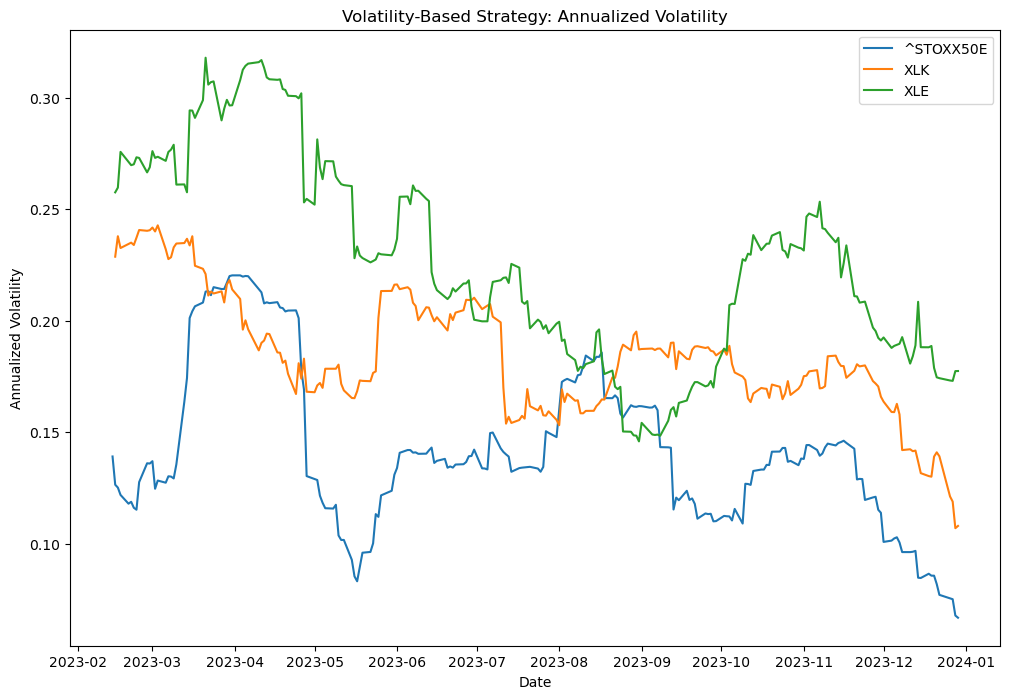

In [7]:
# Calculate annualised volatility
def calculate_volatility(data, window=30):
    volatility = {}
    for ticker, df in data.items():
        returns = df['Adj Close'].pct_change()
        volatility[ticker] = returns.rolling(window=window).std() * (252**0.5)  # Annualize volatility
    return volatility

volatility = calculate_volatility(data, window=30)

# Plot volatility-based strategy
def plot_volatility_strategy(volatility):
    plt.figure(figsize=(12, 8))
    for ticker, vol in volatility.items():
        plt.plot(vol.index, vol, label=ticker)
    plt.title('Volatility-Based Strategy: Annualized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.show()

plot_volatility_strategy(volatility)


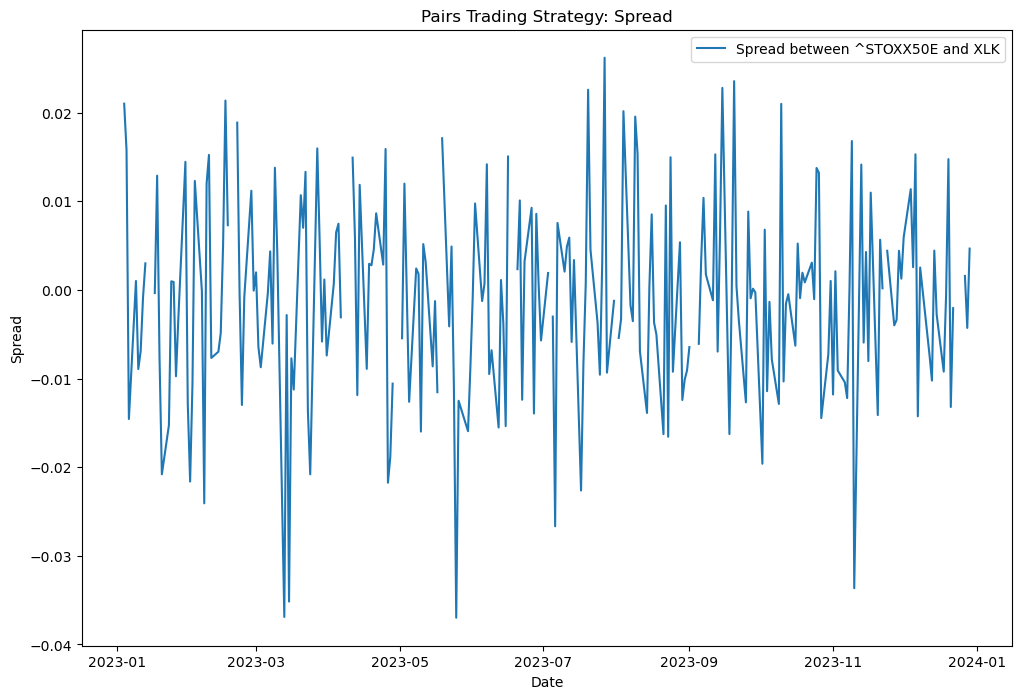

In [8]:
# Identify pairs and plot their spread
def calculate_spread(ticker1, ticker2, returns):
    spread = returns[ticker1] - returns[ticker2]
    return spread

# ^STOXX50E and XLK
spread = calculate_spread('^STOXX50E', 'XLK', daily_returns)

# Plot pairs trading strategy
def plot_pairs_trading_strategy(spread):
    plt.figure(figsize=(12, 8))
    plt.plot(spread.index, spread, label='Spread between ^STOXX50E and XLK')
    plt.title('Pairs Trading Strategy: Spread')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

plot_pairs_trading_strategy(spread)
